In [1]:
# main.py

# Import necessary libraries
import os
import gc
import torch
import pandas as pd
from utils.dataUtils import DataUtils
from utils.modelUtils import ModelUtils
from utils.limeUtils import LIMEUtils
from utils.graphUtils import create_and_save_graph, draw_cluster_graph, draw_soi
from utils.soiUtils import SOIUtils
from utils.ragUtils import RAGUtils
from transformers import AutoTokenizer, AutoModelForCausalLM

# Parameters
dataset_name = 'manjuvallayil/factver_master'
model_name = 'MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli'
embedding_model_name = 'sentence-transformers/all-mpnet-base-v2'
llama_model_name = 'meta-llama/Llama-2-7b-chat-hf'

selected_claim_id = 'Claim_59'
similarity_threshold = 0.75 # delta for cosine similarity
alpha = 0.5 # para for weighted vector combination of thematic embeddding (1 for RAG only) while retrieving the evidence doc
n_docs = 6 # number of docs to retrieve by RAG

# Paths for RAGUtils
passages_path = '/home/qsh5523/Documents/factver_dev/dataset'
index_path = '/home/qsh5523/Documents/factver_dev/faiss/index.faiss'

# Initialize LLaMA model
llama_tokenizer = AutoTokenizer.from_pretrained(llama_model_name)
llama_model = AutoModelForCausalLM.from_pretrained(llama_model_name)

# Initialize utilities
data_utils = DataUtils(dataset_name)
model_utils = ModelUtils(model_name, embedding_model_name)
lime_utils = LIMEUtils(model_utils)
soi_utils = SOIUtils(model_utils)
rag_utils = RAGUtils(passages_path, index_path, embedding_model_name)

# Function to generate LLM-based explanation
def generate_llm_summary(claim, evidences):
    # Clear the GPU cache first
    gc.collect()
    torch.cuda.empty_cache()
    combined_evidence = ' '.join([evidence for evidence in evidences])
    prompt = f"Claim: {claim}\nEvidence: {combined_evidence}\nYou are a fact verification assistant. From the given Claim and its Evidence, determine if the claim is supported by the evidence and generate a concise explanation (two sentences max)."
    
    with torch.no_grad():
        inputs = llama_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
        outputs = llama_model.generate(inputs['input_ids'], max_new_tokens=200)
    
    return llama_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

# Load themed data
theme, themed_data = data_utils.filter_by_theme(selected_claim_id)

# GMM-EM Clustering
# Check if themed data is available
if themed_data.empty:
    print("No data found for the specified theme.")
else:
    # Get embeddings
    all_texts = [row['Claim_text'] for _, row in themed_data.iterrows()]
    for _, row in themed_data.iterrows():
        all_texts.extend(row['Evidence_text'])

    embeddings = model_utils.get_sent_embeddings(all_texts)

    # Cluster embeddings within the selected theme
    labels = model_utils.cluster_embeddings(embeddings)
    unique_labels = set(labels)
    print(f"Unique clusters identified within the theme {theme}: {unique_labels}")
    
    graph_filepath = 'graph.pkl'
    create_and_save_graph(model_utils, themed_data, graph_filepath)

    # Draw cluster graph for the selected theme
    for cluster_id in unique_labels:
        draw_cluster_graph(themed_data, labels, cluster_id=cluster_id, model_utils=model_utils, title=f'{theme} - Cluster Visualization {cluster_id}')

    # Ensure the selected claim is in the identified cluster
    selected_cluster_id = None
    claim_text = None
    annotated_evidences = None

    for index, row in themed_data.iterrows():
        unique_id = row['Claim_topic_id'].split('_')[-1]
        if f"Claim_{unique_id}" == selected_claim_id:
            selected_cluster_id = labels[index]
            claim_text = row['Claim_text']
            annotated_evidences = row['Evidence_text']
            break

    
    # Annotated evidences explanation
    if claim_text is not None and annotated_evidences is not None:
        annotated_explanation = generate_llm_summary(claim_text, annotated_evidences)
        print("\nAnnotated Evidences based Explanation:\n", annotated_explanation)

    if selected_cluster_id is not None:
        print("\n")
        print(f"The selected claim ({selected_claim_id}) belongs to cluster {selected_cluster_id}")

        # Compare RAG (alpha=1.0) vs CARAG (alpha=0.5)

        # 1. RAG-based retrieval and explanation
        rag_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, aggregated_embedding=None, alpha=1.0)
        rag_explanation = generate_llm_summary(claim_text, rag_evidence)
        print("\nRAG Explanation:\n", rag_explanation)
        
        # Compute the SOI
        soi = soi_utils.compute_soi(selected_claim_id, themed_data, labels, selected_cluster_id, similarity_threshold)
        soi_evidences = soi['related_claims'] + soi['annotated_evidences'] + soi['thematic_cluster_evidences']
        #print(f'SOI Evidences: {soi_evidences}')
        print("\n")
        draw_soi(soi, similarity_threshold, title=f'SOI Visualization for {selected_claim_id}')

        # Compute aggregated embedding for the SOI evidences
        aggregated_embedding = rag_utils.compute_aggregated_embedding([evidence for evidence, _ in soi_evidences])
        # Retrieve evidence using the aggregated embedding with CARAG (alpha=0.5)
        agg_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, aggregated_embedding, alpha=0.5)

        
        # 2. Generate explanation using CARAG (retrieved evidence with combined embedding)
        carag_explanation = generate_llm_summary(claim_text, agg_evidence)
        print("\nCARAG Explanation:\n", carag_explanation)
    
    else:
        print(f"Selected claim {selected_claim_id} is not part of any identified cluster.")



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3096 [00:00<?, ? examples/s]

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cuda
INFO:root:Classification model loaded on CUDA
/home/qsh5523/miniconda3/envs/factver_env/lib/python3.10/site-packages/transformers/models/bart/configuration_bart.py:179: UserWarning:

Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class


 The selected Claim belongs to the theme: Climate


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Unique clusters identified within the theme Climate: {0, 1, 2}
Graph created with 638 nodes and 465 edges.
Cluster 0 graph has 209 nodes and 21092 edges after trimming outliers.
Cluster 1 graph has 142 nodes and 9618 edges after trimming outliers.
Cluster 2 graph has 287 nodes and 39547 edges after trimming outliers.

Annotated Evidences based Explanation:
 Claim: The public is unconcerned about a climate emergency
Evidence: That is why this must be the decade of action in tackling the climate emergency and why this Government has pledged to embed our response to it in everything we do. The challenge is huge, and the U.N. has noted that 1.5 degrees Celsius is viewed as being the upper limit when it comes to avoiding the worst consequences of the climate emergency. Todd said it was madness to be investing in roads that increase traffic in a climate emergency. In 2020, she declared a climate emergency. Groundswell NZ held its third nationwide protest, this time against He Waka Eke Noa, l

Batches:   0%|          | 0/3 [00:00<?, ?it/s]


CARAG Explanation:
 Claim: The public is unconcerned about a climate emergency
Evidence: Failure will result in the country's once-successful car making industry being largely consigned to the scrap heap. This greenhouse gas trading scheme forms part of the UK government's ambition to achieve net zero emissions by 2050.Global business is increasingly familiar with the prospect of short-notice public investigatory attention, whether from regulators, law enforcement, political forces or as a consequence of sanctions, and this can  in in some cases  devastate individual and corporate reputation. Cho Tae-yong, ambassador of the Republic of Korea to the U.S., said Tuesday officials are discussing “several possible options” to correct what the country believes to be unfair policies that eliminated up to $7,500 of tax credits for EVs produced outside North America. They could drive back to Israel and get a ferry around the middle east to Qatar - but that is a two-week journey which would hav

In [2]:
import numpy as np
import pandas as pd

# Load dataset and global vectors
dataset_vectors = rag_utils.load_dataset_vectors()  # Global context vectors
print(f"Loaded {len(dataset_vectors)} vectors from the FAISS index.")

# Load the data from the CSV file
data_path = 'results.csv'
df = pd.read_csv(data_path)

# Check for available themes in results.csv
themes = df['Theme'].unique() if 'Theme' in df.columns else []
print(f"Available themes in results.csv: {themes}")

# Step 1: Extract claim IDs and explanations
#df = df[df['Theme'] == 'Climate'] # Covid,Electric_Vehicles,Climate   @ select the theme here for theme based plots
claim_ids = df['Claim_id'].tolist()
annotated_explanations = df['Annotated'].tolist()
rag_explanations = df['RAG'].tolist()
carag_explanations = df['CARAG'].tolist()

# Define function for generating embeddings
def generate_explanation_embeddings(explanations, model_utils):
    explanation_embeddings = model_utils.get_sent_embeddings(explanations)
    return np.atleast_2d(explanation_embeddings)  # Ensure the embeddings are 2D

# Generate embeddings for explanations
annotated_embeddings = generate_explanation_embeddings(annotated_explanations, model_utils)
rag_embeddings = generate_explanation_embeddings(rag_explanations, model_utils)
carag_embeddings = generate_explanation_embeddings(carag_explanations, model_utils)

# Generate themed data embeddings for each theme
themed_data_embeddings = {}
for theme in themes:
    themed_data = data_utils.themed_data(theme)
    if not themed_data.empty:
        # Print a sample of themed_data for verification
        #print(f"Sample data for theme '{theme}':\n", themed_data.head())

        # Flatten list of lists in `Evidence_text`
        valid_evidence_texts = themed_data['Evidence_text'].dropna().tolist()
        valid_evidence_texts_flat = [item for sublist in valid_evidence_texts for item in sublist if isinstance(item, str) and item.strip()]
        
        # Generate embeddings if valid evidence texts exist
        if valid_evidence_texts_flat:
            themed_vectors = model_utils.get_sent_embeddings(valid_evidence_texts_flat)
            themed_data_embeddings[theme] = themed_vectors
            print(f"Generated embeddings for theme '{theme}' with {len(themed_vectors)} vectors.")
        else:
            print(f"No valid evidence texts found for theme '{theme}'.")
    else:
        print(f"No data found for theme '{theme}'")

Loaded 3102 vectors from the FAISS index.
Available themes in results.csv: ['Climate' 'Covid' 'Electric_Vehicles' nan]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Generated embeddings for theme 'Climate' with 486 vectors.


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Generated embeddings for theme 'Covid' with 2004 vectors.


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generated embeddings for theme 'Electric_Vehicles' with 606 vectors.
No data found for theme 'nan'


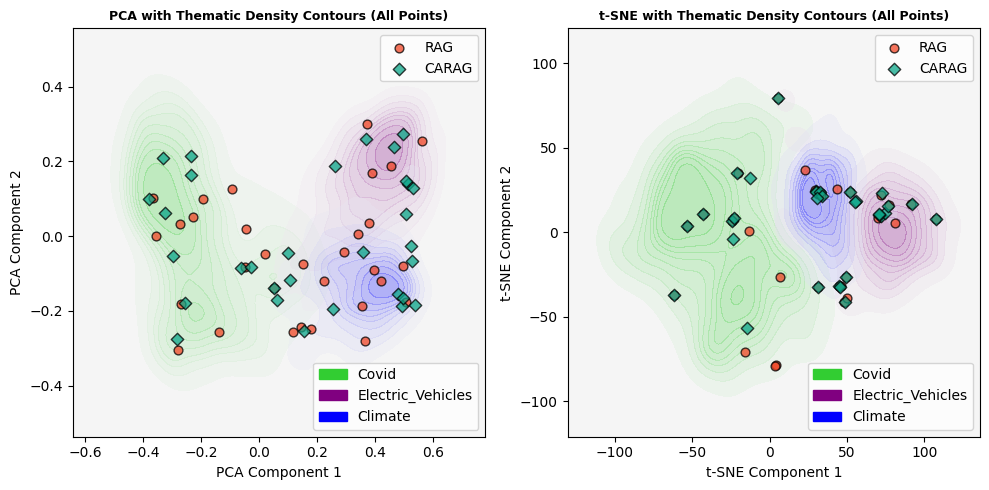

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

# Function to apply t-SNE
def apply_tsne(embeddings):
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)  # Ensure perplexity is less than n_samples
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    return tsne.fit_transform(embeddings)

# Apply PCA and t-SNE transformations to RAG, CARAG, and themed embeddings
all_embeddings = np.vstack([rag_embeddings, carag_embeddings, *themed_data_embeddings.values()])
labels = ['RAG'] * len(rag_embeddings) + ['CARAG'] * len(carag_embeddings) + sum([[theme] * len(vectors) for theme, vectors in themed_data_embeddings.items()], [])

# PCA transformation
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)
rag_pca = pca_embeddings[:len(rag_embeddings)]
carag_pca = pca_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
themed_pca = {
    theme: pca_embeddings[len(rag_embeddings) + len(carag_embeddings) + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i]):][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# t-SNE transformation
tsne_embeddings = apply_tsne(all_embeddings)
rag_tsne = tsne_embeddings[:len(rag_embeddings)]
carag_tsne = tsne_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
themed_tsne = {
    theme: tsne_embeddings[len(rag_embeddings) + len(carag_embeddings) + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i]):][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# Define distinct colors for each theme
theme_colors = {
    'Covid': '#32CD32',
    'Electric_Vehicles': 'purple',
    'Climate': 'blue'    
}

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) #figsize=(8, 4.25)

# PCA plot with separate thematic densities
for theme, color in theme_colors.items():
    sns.kdeplot(x=themed_pca[theme][:, 0], y=themed_pca[theme][:, 1], ax=axes[0], fill=True, cmap=sns.light_palette(color, as_cmap=True), alpha=0.3, label=f'{theme} Contour')
axes[0].scatter(rag_pca[:, 0], rag_pca[:, 1], color="#F24726", edgecolor='black', label='RAG', s=40, alpha=0.75)
axes[0].scatter(carag_pca[:, 0], carag_pca[:, 1], color="#0CA789", edgecolor='black', label='CARAG', s=40, marker='D', alpha=0.75)
axes[0].set_title("PCA with Thematic Density Contours (All Points)", fontsize=9, fontweight='bold')
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].set_facecolor('#f5f5f5')


# t-SNE plot with separate thematic densities
for theme, color in theme_colors.items():
    sns.kdeplot(x=themed_tsne[theme][:, 0], y=themed_tsne[theme][:, 1], ax=axes[1], fill=True, cmap=sns.light_palette(color, as_cmap=True), alpha=0.3, label=f'{theme} Contour')
axes[1].scatter(rag_tsne[:, 0], rag_tsne[:, 1], color="#F24726", edgecolor='black', label='RAG', s=40, alpha=0.75)
axes[1].scatter(carag_tsne[:, 0], carag_tsne[:, 1], color="#0CA789", edgecolor='black', label='CARAG', s=40, marker='D', alpha=0.75)
axes[1].set_title("t-SNE with Thematic Density Contours (All Points)", fontsize=9, fontweight='bold')
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")
axes[1].set_facecolor('#f5f5f5')

# Add the first legend for scatter plot points (RAG and CARAG)
handles_points, labels_points = axes[0].get_legend_handles_labels()
legend_points = axes[0].legend(handles=handles_points, labels=labels_points, loc='upper right') #title='Legend (Points)'


# Add the second legend for thematic colors
theme_legend_patches = [mpatches.Patch(color=color, label=f"{theme}") for theme, color in theme_colors.items()]
legend_theme = axes[0].legend(handles=theme_legend_patches, loc='lower right') #title='Legend (Themes)'

# Add the first legend back manually
axes[0].add_artist(legend_points)

# Repeat for the second plot (t-SNE)
handles_points_tsne, labels_points_tsne = axes[1].get_legend_handles_labels()
legend_points_tsne = axes[1].legend(handles=handles_points_tsne, labels=labels_points_tsne, loc='upper right') #title='Legend (Points)'

legend_theme_tsne = axes[1].legend(handles=theme_legend_patches, loc='lower right') #title='Legend (Themes)'

axes[1].add_artist(legend_points_tsne)

# Layout and show the plot
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from IPython.display import display

# Load the data from results.csv
data_path = 'results.csv'
df = pd.read_csv(data_path)

# Check for available themes and exclude `nan`
themes = [theme for theme in df['Theme'].unique() if pd.notna(theme)]
print(f"Available themes in results.csv (excluding nan): {themes}")

# Filter RAG and CARAG points by theme from the CSV file
rag_points = {theme: rag_pca[np.array(df[df['Theme'] == theme].index)] for theme in themes}
carag_points = {theme: carag_pca[np.array(df[df['Theme'] == theme].index)] for theme in themes}

# Step 1: Calculate the centroids of each theme contour
theme_centroids_pca = {theme: np.mean(themed_pca[theme], axis=0) for theme in themes}
theme_centroids_tsne = {theme: np.mean(themed_tsne[theme], axis=0) for theme in themes}

# Step 2: Calculate distances of RAG points to theme centroids (PCA and t-SNE)
rag_distances_pca = {theme: cdist(rag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
rag_distances_tsne = {theme: cdist(rag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 3: Calculate distances of CARAG points to theme centroids (PCA and t-SNE)
carag_distances_pca = {theme: cdist(carag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
carag_distances_tsne = {theme: cdist(carag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 4: Prepare DataFrames for RAG and CARAG distances with difference column
theme_tables = {}
for theme in themes:
    theme_table = []
    for i in range(len(rag_distances_pca[theme])):
        theme_table.append({
            "Theme": theme,
            "Point Index": i,
            "RAG Distance (PCA)": rag_distances_pca[theme][i],
            "CARAG Distance (PCA)": carag_distances_pca[theme][i],
            "Difference (PCA)": carag_distances_pca[theme][i] - rag_distances_pca[theme][i],
            "RAG Distance (t-SNE)": rag_distances_tsne[theme][i],
            "CARAG Distance (t-SNE)": carag_distances_tsne[theme][i],
            "Difference (t-SNE)": carag_distances_tsne[theme][i] - rag_distances_tsne[theme][i]
        })
    theme_tables[theme] = pd.DataFrame(theme_table)

# Display theme-specific tables
for theme, table in theme_tables.items():
    print(f"\nEuclidean Distance Table for Theme: {theme}")
    display(table)

# Step 5: Prepare a combined alignment comparison table
alignment_comparison = []
for theme in themes:
    rag_avg_distance_pca = np.mean(rag_distances_pca[theme])
    carag_avg_distance_pca = np.mean(carag_distances_pca[theme])
    rag_avg_distance_tsne = np.mean(rag_distances_tsne[theme])
    carag_avg_distance_tsne = np.mean(carag_distances_tsne[theme])

    alignment_comparison.append({
        "Theme": theme,
        "RAG Avg Distance (PCA)": rag_avg_distance_pca,
        "CARAG Avg Distance (PCA)": carag_avg_distance_pca,
        "Difference (PCA)": carag_avg_distance_pca - rag_avg_distance_pca,
        "RAG Avg Distance (t-SNE)": rag_avg_distance_tsne,
        "CARAG Avg Distance (t-SNE)": carag_avg_distance_tsne,
        "Difference (t-SNE)": carag_avg_distance_tsne - rag_avg_distance_tsne,
        "Better Alignment (PCA)": "CARAG" if carag_avg_distance_pca < rag_avg_distance_pca else "RAG",
        "Better Alignment (t-SNE)": "CARAG" if carag_avg_distance_tsne < rag_avg_distance_tsne else "RAG"
    })

# Convert alignment comparison to a DataFrame
alignment_df = pd.DataFrame(alignment_comparison)

# Display the combined alignment comparison table
print("\nCombined Alignment Comparison Table:")
display(alignment_df)

# Optionally save all tables
for theme, table in theme_tables.items():
    filename = f"euclidean_distance_table_{theme}.csv"
    table.to_csv(filename, index=False)
    print(f"Saved table for theme '{theme}' as '{filename}'.")

alignment_df.to_csv("alignment_comparison.csv", index=False)
print("Saved combined alignment comparison table as 'alignment_comparison.csv'.")

Available themes in results.csv (excluding nan): ['Climate', 'Covid', 'Electric_Vehicles']

Euclidean Distance Table for Theme: Climate


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),Difference (PCA),RAG Distance (t-SNE),CARAG Distance (t-SNE),Difference (t-SNE)
0,Climate,0,0.059030,0.662553,0.603523,37.331585,37.860293,0.528708
1,Climate,1,0.217946,0.123379,-0.094568,37.516338,37.202416,-0.313922
2,Climate,2,0.053129,0.144141,0.091012,37.250439,37.206090,-0.044350
3,Climate,3,0.151729,0.253356,0.101628,37.360954,37.523220,0.162266
4,Climate,4,0.155139,0.139708,-0.015431,37.189063,37.195024,0.005961
5,Climate,5,0.136760,0.085568,-0.051192,37.419162,37.265343,-0.153819
6,Climate,6,0.274864,0.187793,-0.087071,37.575015,37.163568,-0.411446
7,Climate,7,0.347325,0.192995,-0.154330,37.568913,37.108231,-0.460682
8,Climate,8,0.146106,0.178925,0.032819,37.155142,37.122282,-0.032861
9,Climate,9,0.514269,0.125149,-0.389120,37.804392,37.424686,-0.379706



Euclidean Distance Table for Theme: Covid


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),Difference (PCA),RAG Distance (t-SNE),CARAG Distance (t-SNE),Difference (t-SNE)
0,Covid,0,0.113362,0.226375,0.113013,31.585078,31.560839,-0.024239
1,Covid,1,0.142302,0.250559,0.108257,31.412050,31.466472,0.054422
2,Covid,2,0.299944,0.271953,-0.027992,31.441912,31.444447,0.002535
3,Covid,3,0.191259,0.199535,0.008275,31.415804,31.403046,-0.012758
4,Covid,4,0.064497,0.135407,0.070910,31.543997,31.449218,-0.094778
5,Covid,5,0.177888,0.173559,-0.004329,31.471169,31.484336,0.013167
6,Covid,6,0.180981,0.176783,-0.004198,31.687798,31.555808,-0.131990
7,Covid,7,0.640456,0.168723,-0.471733,32.159837,31.689486,-0.470351
8,Covid,8,0.368755,0.199422,-0.169333,31.901124,31.724230,-0.176893
9,Covid,9,0.552367,0.317767,-0.234599,32.099226,31.800485,-0.298741



Euclidean Distance Table for Theme: Electric_Vehicles


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),Difference (PCA),RAG Distance (t-SNE),CARAG Distance (t-SNE),Difference (t-SNE)
0,Electric_Vehicles,0,0.198932,0.115518,-0.083414,76.122644,76.174841,0.052197
1,Electric_Vehicles,1,0.679563,0.140492,-0.539071,76.962114,76.423656,-0.538458
2,Electric_Vehicles,2,0.498360,0.109293,-0.389068,76.738308,76.180876,-0.557433
3,Electric_Vehicles,3,0.111190,0.133840,0.022650,76.311448,76.157455,-0.153993
4,Electric_Vehicles,4,0.462736,0.466840,0.004104,76.550442,76.540903,-0.009539
5,Electric_Vehicles,5,0.026090,0.164287,0.138197,76.297911,76.187116,-0.110795
6,Electric_Vehicles,6,0.156480,0.118811,-0.037670,76.311969,76.317858,0.005889
7,Electric_Vehicles,7,0.215114,0.140267,-0.074847,76.398621,76.180788,-0.217833
8,Electric_Vehicles,8,0.460728,0.352226,-0.108502,76.735371,76.590101,-0.145270
9,Electric_Vehicles,9,0.071837,0.115961,0.044124,76.231776,76.219865,-0.011911



Combined Alignment Comparison Table:


,Theme,RAG Avg Distance (PCA),CARAG Avg Distance (PCA),Difference (PCA),RAG Avg Distance (t-SNE),CARAG Avg Distance (t-SNE),Difference (t-SNE),Better Alignment (PCA),Better Alignment (t-SNE)
0,Climate,0.205630,0.209357,0.003727,37.417100,37.307115,-0.109985,RAG,CARAG
1,Covid,0.273181,0.212008,-0.061173,31.671799,31.557837,-0.113963,CARAG,CARAG
2,Electric_Vehicles,0.288103,0.185753,-0.102350,76.466061,76.297346,-0.168715,CARAG,CARAG


Saved table for theme 'Climate' as 'euclidean_distance_table_Climate.csv'.
Saved table for theme 'Covid' as 'euclidean_distance_table_Covid.csv'.
Saved table for theme 'Electric_Vehicles' as 'euclidean_distance_table_Electric_Vehicles.csv'.
Saved combined alignment comparison table as 'alignment_comparison.csv'.


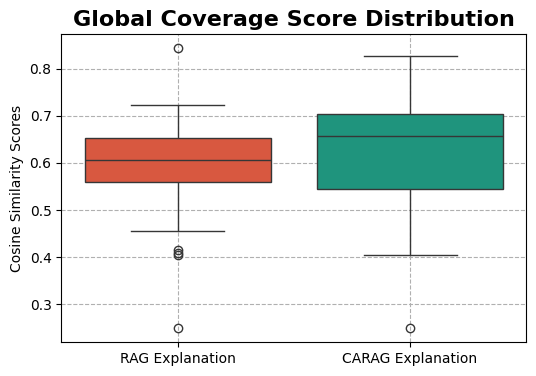

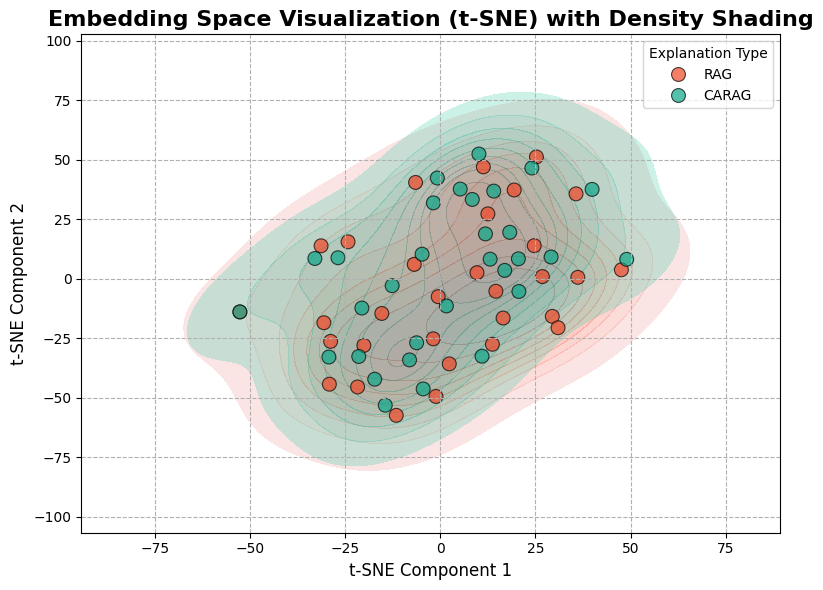

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute Global Coverage Scores
def compute_global_coverage(explanation_embeddings, dataset_vectors, top_k=10):
    scores = []
    for explanation_embedding in explanation_embeddings:
        explanation_embedding = explanation_embedding.reshape(1, -1)
        similarities = cosine_similarity(explanation_embedding, dataset_vectors)[0]
        top_k_similarities = np.sort(similarities)[-top_k:]
        scores.append(np.mean(top_k_similarities))
    return scores

# Function to visualize Global Coverage Scores using boxplot
def visualize_global_coverage(rag_scores, carag_scores):
    data = {
        "RAG Explanation": rag_scores,
        "CARAG Explanation": carag_scores
    }
    df = pd.DataFrame.from_dict(data, orient='index').transpose()

    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, palette=["#F24726", "#0CA789"])
    plt.title("Global Coverage Score Distribution", fontsize=16, fontweight='bold')
    plt.ylabel("Cosine Similarity Scores")
    plt.grid(True, linestyle='--')
    plt.show()

# Function to visualize embedding space with t-SNE and density shading
def visualize_embedding_space_with_tsne(rag_embeddings, carag_embeddings):
    all_embeddings = np.vstack([rag_embeddings, carag_embeddings])
    labels = ['RAG'] * len(rag_embeddings) + ['CARAG'] * len(carag_embeddings)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=15)
    reduced_embeddings = tsne.fit_transform(all_embeddings)

    # Convert to DataFrame for easy plotting
    tsne_df = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])
    tsne_df['Label'] = labels

    # Plot with density shading
    plt.figure(figsize=(8, 6))
    sns.kdeplot(
        data=tsne_df[tsne_df['Label'] == 'RAG'], x="Component 1", y="Component 2", 
        fill=True, color="#F24726", alpha=0.3, label="RAG"
    )
    sns.kdeplot(
        data=tsne_df[tsne_df['Label'] == 'CARAG'], x="Component 1", y="Component 2", 
        fill=True, color="#0CA789", alpha=0.3, label="CARAG"
    )

    # Scatter plot overlaid with density shading
    sns.scatterplot(
        data=tsne_df, x="Component 1", y="Component 2", hue="Label", 
        palette={"RAG": "#F24726", "CARAG": "#0CA789"}, edgecolor='black', s=100, alpha=0.7
    )

    # Adjust legend and titles
    plt.legend(title='Explanation Type')
    plt.title("Embedding Space Visualization (t-SNE) with Density Shading", fontsize=16, fontweight='bold')
    plt.xlabel("t-SNE Component 1", fontsize=12)
    plt.ylabel("t-SNE Component 2", fontsize=12)
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

# Compute Global Coverage Scores
rag_scores = compute_global_coverage(rag_embeddings, dataset_vectors, top_k=10)
carag_scores = compute_global_coverage(carag_embeddings, dataset_vectors, top_k=10)

# Visualize Global Coverage and Embedding Space
visualize_global_coverage(rag_scores, carag_scores)
visualize_embedding_space_with_tsne(rag_embeddings, carag_embeddings)